<a href="https://colab.research.google.com/github/lakshitha-018/major_project/blob/main/Copy_of_Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import warnings
import re
import string
import random
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer , TweetTokenizer
from nltk.stem import WordNetLemmatizer ,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict
from collections import Counter
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


nlp = spacy.load("en_core_web_sm")
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("twitter_training.csv", header = None ,names=['number' , 'Border' , 'label' , 'message'])


In [ ]:
display(df.head())

,number,Border,label,message
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
display(df['label'].value_counts())

,count
label,
Negative,22542
Positive,20832
Neutral,18318
Irrelevant,12990


In [ ]:


df.drop(['Border' , 'number'] , axis=1 , inplace = True)

In [ ]:

df.shape

(74682, 2)

In [ ]:
df.isnull().sum()

,0
label,0
message,686


In [ ]:
#Let's Drop the null rows !
df.dropna(inplace = True)

In [ ]:
df.shape

(73996, 2)

# Pre-Processing

In [ ]:
# 1st - LowerCasing text¶
df['message'] = df['message'].str.lower()

df.head()

,label,message
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,i am coming to the borders and i will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
# 2 - Removing HTML tags !
from bs4 import BeautifulSoup

def remove_html(text):

    clean_text = BeautifulSoup(text , 'html.parser')

    return clean_text.get_text()

In [ ]:
#  3 - Removing URLs (using regular expression (regex)
import re

def clean_url(text):

    return re.sub(r'http\S+|www\S+', '', text)


In [ ]:
df['message'] = df['message'].apply(clean_url)

df.head()

,label,message
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,i am coming to the borders and i will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
# 4 - Removing punctuation
def remove_punctuation(text):

    return re.sub(r'[^\w\s]', '', text)

In [ ]:
df['message'] = df['message'].apply(remove_punctuation)

df.head()

,label,message
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,i am coming to the borders and i will kill you...
2,Positive,im getting on borderlands and i will kill you all
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
# 5 - Removing Stop words
import spacy

nlp = spacy.load("en_core_web_sm")

def remove_stopwords(text):
    if not isinstance(text, str):  # Handle non-string inputs
        return text

    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_stop])

In [ ]:
df['message'] = df['message'].apply(remove_stopwords)
df.head()

,label,message
0,Positive,m getting borderlands murder
1,Positive,coming borders kill
2,Positive,m getting borderlands kill
3,Positive,m coming borderlands murder
4,Positive,m getting borderlands 2 murder


In [ ]:
# 6 - Removing Emojis
! pip install emoji
import emoji

def remove_emojis(text):
    return emoji.demojize(text)

df['message'] = df['message'].apply(remove_emojis)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 14.0 MB/s eta 0:00:00


In [ ]:
# 7 - Lemmatization
def lemmatize_text(text):

    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

df['message_lemmatized'] = df['message'].apply(lemmatize_text)


In [ ]:
df.head()

,label,message,message_lemmatized
0,Positive,m getting borderlands murder,m get borderland murder
1,Positive,coming borders kill,come border kill
2,Positive,m getting borderlands kill,m get borderland kill
3,Positive,m coming borderlands murder,m come borderland murder
4,Positive,m getting borderlands 2 murder,m get borderland 2 murder


In [ ]:
# for future purposes
def clean_text(text):
    if not isinstance(text, str):  # Handle non-string inputs
        return text

    text = text.lower()  # 1️⃣ Convert to lowercase
    text = remove_html(text)  # 2️⃣ Remove HTML
    text = clean_url(text)  # 3️⃣ Remove URLs
    text = remove_punctuation(text)  # 4️⃣ Remove punctuation
    text = remove_stopwords(text)  # 5️⃣ Remove stopwords
    text = remove_emojis(text)  # 6️⃣ Remove emojis
    text = lemmatize_text(text)  # 7️⃣ Lemmatization

    return text

In [ ]:
new_text = "Heyyyy!!! 😊 Check this out: https://example.com <b>Awesome!</b>"
cleaned_text = clean_text(new_text)
print(cleaned_text)

heyyyy    check    awesome


# Word Cloud

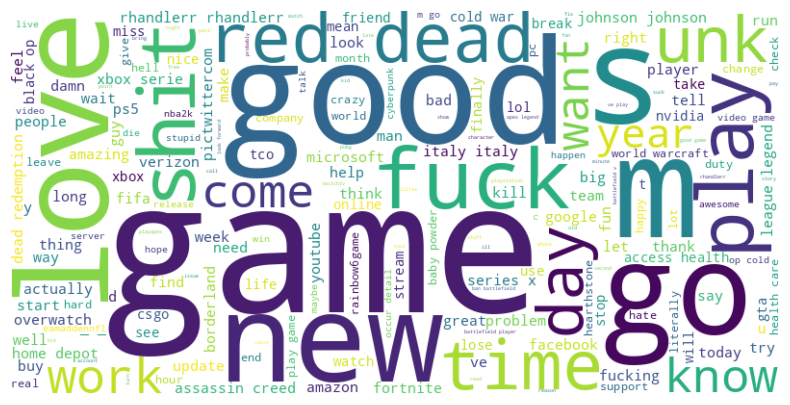

In [ ]:
from wordcloud import WordCloud

# Convert the column to a single string
text = df['message_lemmatized'].astype(str).str.cat(sep=" ")

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

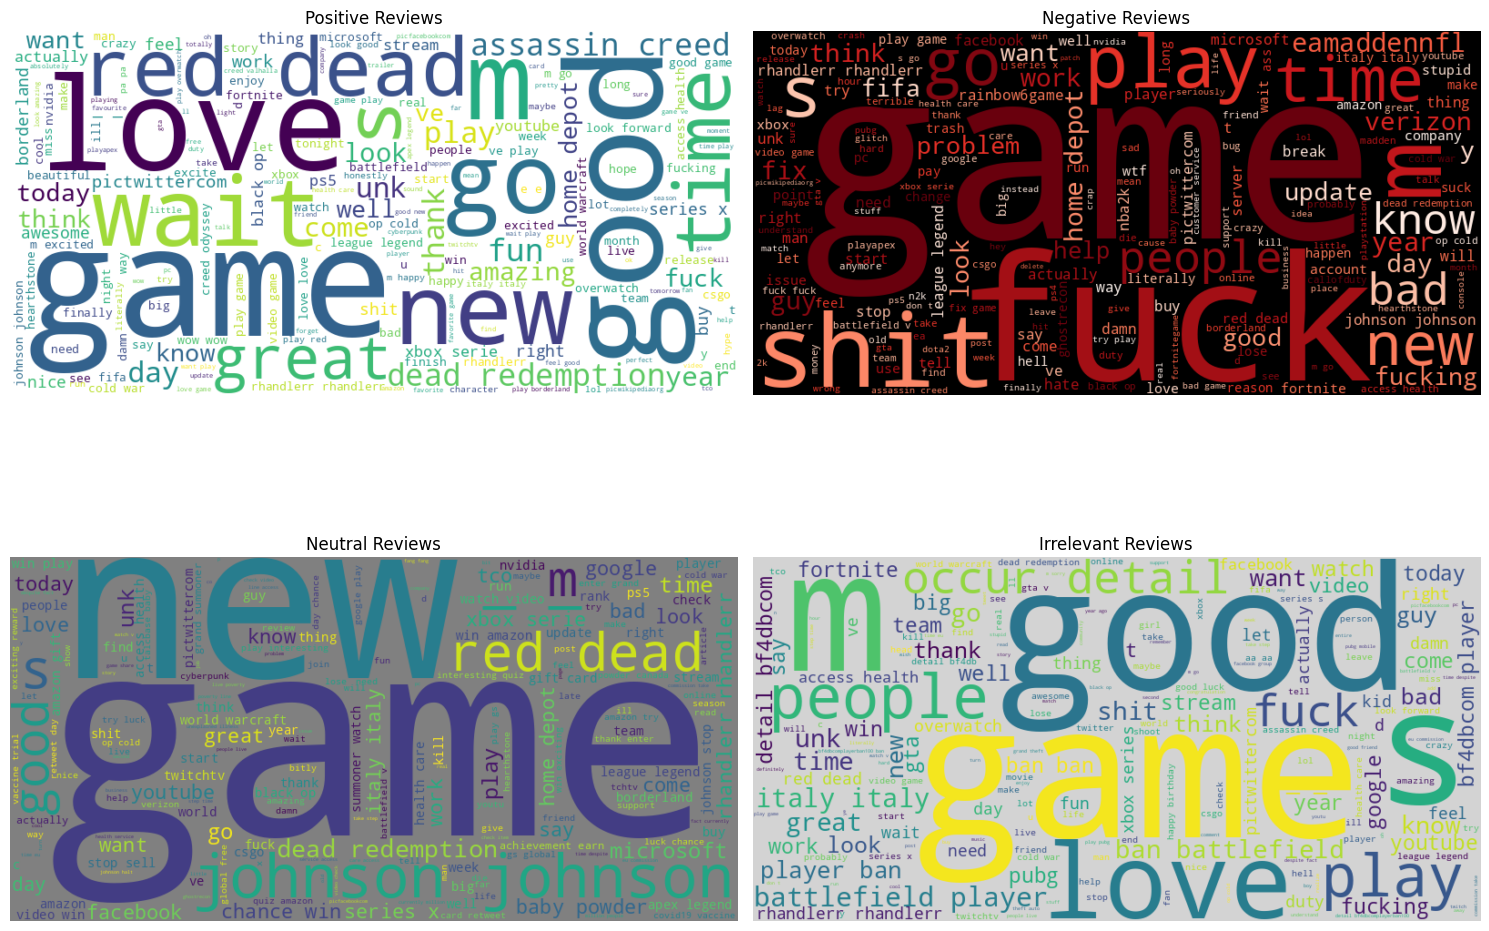

In [ ]:
# word cloud of the +ve sentences and the -ve according to the data

# Combine text data for each sentiment category
positive_text = " ".join(df[df["label"] == "Positive"]["message_lemmatized"])
negative_text = " ".join(df[df["label"] == "Negative"]["message_lemmatized"])
neutral_text = " ".join(df[df["label"] == "Neutral"]["message_lemmatized"])
irrelevant_text = " ".join(df[df["label"] == "Irrelevant"]["message_lemmatized"])

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)
neutral_wordcloud = WordCloud(width=800, height=400, background_color='gray').generate(neutral_text)
irrelevant_wordcloud = WordCloud(width=800, height=400, background_color='lightgray').generate(irrelevant_text)

# Plot word clouds
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

ax[0, 0].imshow(positive_wordcloud, interpolation='bilinear')
ax[0, 0].set_title("Positive Reviews")
ax[0, 0].axis("off")

ax[0, 1].imshow(negative_wordcloud, interpolation='bilinear')
ax[0, 1].set_title("Negative Reviews")
ax[0, 1].axis("off")

ax[1, 0].imshow(neutral_wordcloud, interpolation='bilinear')
ax[1, 0].set_title("Neutral Reviews")
ax[1, 0].axis("off")

ax[1, 1].imshow(irrelevant_wordcloud, interpolation='bilinear')
ax[1, 1].set_title("Irrelevant Reviews")
ax[1, 1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
df["message_lemmatized"] = df["message_lemmatized"].str.replace(r'\bgame\b', '', regex=True)

In [ ]:
df['label'].value_counts()

,count
label,
Negative,22358
Positive,20655
Neutral,18108
Irrelevant,12875


# basic eda

In [ ]:
sample_size = 3

df.groupby('label').apply(lambda x: x.sample(sample_size))

<ipython-input-60-e69117b63447>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('label').apply(lambda x: x.sample(sample_size))


label  \
label                          
Irrelevant 2871   Irrelevant   
           39770  Irrelevant   
           3963   Irrelevant   
Negative   44647    Negative   
           31618    Negative   
           64135    Negative   
Neutral    38879     Neutral   
           6794      Neutral   
           22250     Neutral   
Positive   37027    Positive   
           27891    Positive   
           1637     Positive   

                                                            message  \
label                                                                 
Irrelevant 2871     shitting non preorder   twitchtvgreasysunnyvale   
           39770  ban battlefield 4 player jocerworld occupied d...   
           3963                     middle baghdad reason trickshot   
Negative   44647                      time eu commission taken step   
           31618  faders constant problem people nt stand battle...   
           64135  dear   easports _ mut   eamaddennfl fix broken...   
Neutral    38879  pathetic freeze stop minions   rules reality g...   
           6794   pathetic feel knowing cage penguin chained car...   
           22250               3 church csgo tchtv   whishy _ fishy   
Positive   37027  apps useful lately life comfortable merriam we...   
           27891                     soo fun arc kicks actually hit   
           1637                                                       

                                                 message_lemmatized  
label                                                                
Irrelevant 2871        shit non preorder    twitchtvgreasysunnyvale  
           39770  ban battlefield 4 player jocerworld occupy det...  
           3963                     middle baghdad reason trickshot  
Negative   44647                       time eu commission take step  
           31618  fader constant problem people not stand battle...  
           64135  dear    easport _ mut    eamaddennfl fix broke...  
Neutral    38879  pathetic freeze stop minion    rule reality ga...  
           6794   pathetic feel know cage penguin chain caricatu...  
           22250              3 church csgo tchtv    whishy _ fishy  
Positive   37027  app useful lately life comfortable merriam web...  
           27891                      soo fun arc kick actually hit  
           1637

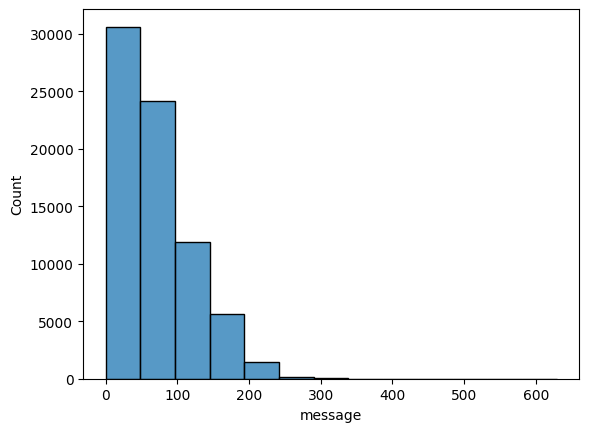

In [ ]:
sns.histplot(df["message"].str.len(), binwidth=50)
plt.show()

In [ ]:

df["sentiment"]=df["label"]
labels = list(df['sentiment'].unique())
id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for k,v in enumerate(labels)}
print(labels)
print(id2label)
print(label2id)
df.drop(["label",],axis=1, inplace=True)

['Positive', 'Neutral', 'Negative', 'Irrelevant']
{0: 'Positive', 1: 'Neutral', 2: 'Negative', 3: 'Irrelevant'}
{'Positive': 0, 'Neutral': 1, 'Negative': 2, 'Irrelevant': 3}


In [ ]:
df

,message,message_lemmatized,sentiment
0,m getting borderlands murder,m get borderland murder,Positive
1,coming borders kill,come border kill,Positive
2,m getting borderlands kill,m get borderland kill,Positive
3,m coming borderlands murder,m come borderland murder,Positive
4,m getting borderlands 2 murder,m get borderland 2 murder,Positive
...,...,...,...
74677,realized windows partition mac like 6 years nv...,realize windows partition mac like 6 year nvid...,Positive
74678,realized mac window partition 6 years nvidia d...,realize mac window partition 6 year nvidia dri...,Positive
74679,realized windows partition mac 6 years nvidia ...,realize windows partition mac 6 year nvidia dr...,Positive
74680,realized windows partition mac like 6 years nv...,realize windows partition mac like 6 year nvid...,Positive


In [ ]:
test_df=pd.read_csv("twitter_validation.csv",names=["id", "entity", "sentiment", "text"])

In [ ]:
train_df=df


In [ ]:
test_df

,id,entity,sentiment,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [ ]:
train_df['label'] = train_df['sentiment'].map(label2id)
test_df['label'] = test_df['sentiment'].map(label2id)

train_df.head()
test_df.head()

,id,entity,sentiment,text,label
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...,3
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,1
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,2
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",2
4,4433,Google,Neutral,Now the President is slapping Americans in the...,1


In [ ]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment"

In [ ]:
# Split train_df into 90% training + 10% validation

train = train_df.sample(frac=0.9, random_state=42)
valid = train_df.drop(train.index)

In [ ]:
train


,message,message_lemmatized,sentiment,label
61413,looks like failed check way moving vehicle cle...,look like fail check way move vehicle clearly ...,Irrelevant,3
44887,wow takes sorts crazy people language proved s...,wow take sort crazy people language prove s lady,Irrelevant,3
73662,nvidia unveils worlds fastest gaming monitor ...,nvidia unveil world fast gaming monitor bre...,Neutral,1
36694,huge radio play reinvention corporate evolut...,huge radio play reinvention corporate evolu...,Neutral,1
2308,happy,happy,Negative,2
...,...,...,...,...
49694,end day fuck fifa,end day fuck fifa,Negative,2
72514,1 great job guys peter_shirley withyounotsmwhr,1 great job guy peter_shirley withyounotsmwhr,Positive,0
20154,thought warcraft 3 ugly game remake basically ...,think warcraft 3 ugly remake basically highre...,Negative,2
29134,el loba,el loba,Neutral,1


In [ ]:
!pip install datasets
from datasets import Dataset

train_ds = Dataset.from_pandas(train)
valid_ds = Dataset.from_pandas(valid)
test_ds = Dataset.from_pandas(test_df)

train_ds, valid_ds, test_ds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

(Dataset({
     features: ['message', 'message_lemmatized', 'sentiment', 'label', '__index_level_0__'],
     num_rows: 66596
 }),
 Dataset({
     features: ['message', 'message_lemmatized', 'sentiment', 'label', '__index_level_0__'],
     num_rows: 7400
 }),
 Dataset({
     features: ['id', 'entity', 'sentiment', 'text', 'label'],
     num_rows: 1000
 }))

In [ ]:
train_ds['message_lemmatized'][0]

'look like fail check way move vehicle clearly right way guess stupidity'

# Load dataset

In [ ]:
# Split train_df into 90% training + 10% validation

train = train_df.sample(frac=0.9, random_state=42)
valid = train_df.drop(train.index)

# preprosseing

In [ ]:
# Dynamic Padding
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
!pip install evaluate

import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# model

# cardiffnlp/twitter-roberta-base-sentiment-latest

In [ ]:
from transformers import pipeline

# Load the classification pipeline with the specified model
pipe = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

# Classify a new sentence
sentence = "I love this product! It's amazing and works perfectly."
result = pipe(sentence)

# Print the result
print(result)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


[{'label': 'positive', 'score': 0.9890263676643372}]


In [ ]:

from transformers import pipeline
import pandas as pd
from sklearn.metrics import accuracy_score

# Load your test dataframe
#test_df = pd.read_csv("twitter_validation.csv")  # if needed

# Load the sentiment analysis pipeline
pipe = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

# Apply the pipeline to each row in the DataFrame
test_df["predicted_label"] = test_df["text"].apply(lambda x: pipe(x)[0]["label"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
test_df = test_df[test_df['sentiment'] != 'Irrelevant']
test_df['sentiment'] = test_df['sentiment'].str.lower()

In [ ]:
test_df



,id,entity,sentiment,text,predicted_label
1,352,Amazon,neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,neutral
2,8312,Microsoft,negative,@Microsoft Why do I pay for WORD when it funct...,negative
3,4371,CS-GO,negative,"CSGO matchmaking is so full of closet hacking,...",negative
4,4433,Google,neutral,Now the President is slapping Americans in the...,negative
5,6273,FIFA,negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,negative
...,...,...,...,...,...
993,314,Amazon,negative,Please explain how this is possible! How can t...,negative
994,9701,PlayStation5(PS5),positive,Good on Sony. As much as I want to see the new...,positive
997,2652,Borderlands,positive,Today sucked so it’s time to drink wine n play...,negative
998,8069,Microsoft,positive,Bought a fraction of Microsoft today. Small wins.,positive


In [ ]:
# Calculate accuracy
accuracy = accuracy_score(test_df["sentiment"], test_df["predicted_label"])

print(f"Model Accuracy: {accuracy:.2%}")


Model Accuracy: 66.55%


# nlptown/bert-base-multilingual-uncased-sentiment

In [ ]:
from transformers import pipeline
import pandas as pd
from sklearn.metrics import accuracy_score

# Load your test dataframe
# test_df = pd.read_csv("your_file.csv")  # if needed

# Load the sentiment analysis pipeline
pipe = pipeline("text-classification", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Apply the pipeline to each row in the DataFrame
test_df["predicted_label"] = test_df["text"].apply(lambda x: pipe(x)[0]["label"])


Device set to use cuda:0


In [ ]:
test_df

,id,entity,sentiment,text,predicted_label,raw_prediction,predicted_sentiment
1,352,Amazon,neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,1 star,1 star,negative
2,8312,Microsoft,negative,@Microsoft Why do I pay for WORD when it funct...,1 star,1 star,negative
3,4371,CS-GO,negative,"CSGO matchmaking is so full of closet hacking,...",1 star,1 star,negative
4,4433,Google,neutral,Now the President is slapping Americans in the...,1 star,1 star,negative
5,6273,FIFA,negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,1 star,1 star,negative
...,...,...,...,...,...,...,...
993,314,Amazon,negative,Please explain how this is possible! How can t...,1 star,1 star,negative
994,9701,PlayStation5(PS5),positive,Good on Sony. As much as I want to see the new...,4 stars,4 stars,positive
997,2652,Borderlands,positive,Today sucked so it’s time to drink wine n play...,1 star,1 star,negative
998,8069,Microsoft,positive,Bought a fraction of Microsoft today. Small wins.,2 stars,2 stars,neutral


In [ ]:
def map_stars_to_sentiment(label):
    if "4" in label or "5" in label or "3" in label:
        return "positive"
    elif "2" in label:
        return "neutral"
    else:
        return "negative"


In [ ]:

test_df["predicted_sentiment"] = test_df["predicted_label"].apply(map_stars_to_sentiment)


In [ ]:
test_df

,id,entity,sentiment,text,predicted_label,raw_prediction,predicted_sentiment
1,352,Amazon,neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,1 star,1 star,negative
2,8312,Microsoft,negative,@Microsoft Why do I pay for WORD when it funct...,1 star,1 star,negative
3,4371,CS-GO,negative,"CSGO matchmaking is so full of closet hacking,...",1 star,1 star,negative
4,4433,Google,neutral,Now the President is slapping Americans in the...,1 star,1 star,negative
5,6273,FIFA,negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,1 star,1 star,negative
...,...,...,...,...,...,...,...
993,314,Amazon,negative,Please explain how this is possible! How can t...,1 star,1 star,negative
994,9701,PlayStation5(PS5),positive,Good on Sony. As much as I want to see the new...,4 stars,4 stars,positive
997,2652,Borderlands,positive,Today sucked so it’s time to drink wine n play...,1 star,1 star,negative
998,8069,Microsoft,positive,Bought a fraction of Microsoft today. Small wins.,2 stars,2 stars,neutral


In [ ]:
# Calculate accuracy
accuracy = accuracy_score(test_df["sentiment"], test_df["predicted_sentiment"])

print(f"Model Accuracy: {accuracy:.2%}")

Model Accuracy: 52.05%


# my model


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

columns = ['id', 'country', 'Label', 'Text']
df = pd.read_csv("twitter_training.csv", names=columns)
df.dropna(inplace=True)

# Encode Labels
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Text'])
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(df['Text'])
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['Label'], test_size=0.2, random_state=42, stratify=df['Label'])

# Model Architecture
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    BatchNormalization(),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

# Compile Model
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Learning Rate Scheduler
callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-5)

# Train Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64, callbacks=[callback])

# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification Report
from sklearn.metrics import classification_report
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=le.classes_))

Epoch 1/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.4893 - loss: 1.1493 - val_accuracy: 0.7686 - val_loss: 0.6437 - learning_rate: 0.0010
Epoch 2/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - accuracy: 0.8305 - loss: 0.4979 - val_accuracy: 0.8501 - val_loss: 0.4278 - learning_rate: 0.0010
Epoch 3/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.9000 - loss: 0.2933 - val_accuracy: 0.8675 - val_loss: 0.3783 - learning_rate: 0.0010
Epoch 4/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.9205 - loss: 0.2232 - val_accuracy: 0.8827 - val_loss: 0.3726 - learning_rate: 0.0010
Epoch 5/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.9308 - loss: 0.1955 - val_accuracy: 0.8876 - val_loss: 0.3697 - learning_rate: 0.0010
Epoch 6/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.9408 - loss: 0.1608 - val_accuracy: 0.8839 - val_loss: 0.3883 - learning_rate: 0.0010
Epoch 7/10
924/925 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9440 - lo